In [3]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# bob用のリスト
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# alice用のリスト
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000
print(f'zenith_angle_alice_deg: {zenith_angle_alice_lst}')
print(f'zenith_angle_bob_deg: {zenith_angle_bob_lst}')


zenith_angle_alice_deg: [59.82220731 57.20571    54.31536344 51.11731306 47.5796426  43.67872882
 39.41103877 34.81442487 30.00638313 25.25323752 21.08758441 18.41782064
 18.22698246 20.60210441 24.62188856 29.33180312 34.15113304 38.78495184
 43.10028831 47.05110381 50.63677524 53.87901238 56.80904791 59.46070142
 61.86681358]
zenith_angle_bob_deg: [59.12231128 56.36761957 53.29942595 49.86960124 46.02580343 41.71462467
 36.88795594 31.51443373 25.59889386 19.2177631  12.61487602  6.7674352
  6.48171328 12.17404931 18.77234156 25.17778075 31.12682233 36.53619297
 41.39769812 45.74103304 49.61362622 53.06877427 56.15900865 58.93278366
 61.43314946]


In [4]:
tau_zen_lst = np.array([0.81])
# tau_zen_lst = np.array([0.81])
print(n_s)

qber_alice_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
yield_alice_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
qber_bob_values = np.zeros((len(tau_zen_lst), len(zenith_angle_bob_lst)))
yield_bob_values = np.zeros((len(tau_zen_lst), len(zenith_angle_bob_lst)))
qber_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
yield_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
skr_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
error_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

0.1


In [5]:
print(f"tau_zen_lst: {tau_zen_lst}")
for idx in range(len(tau_zen_lst)):
    print(f"tau_zen = {tau_zen_lst[idx]}")
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        print(f"zenith_angle_alice = {zenith_angle_alice_lst[jdx]}")
        # print(f"zenith_angle_alice = {zenith_angle_alice_lst[jdx]}")
        
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        
        w_L_alice = slant_path_alice_lst[jdx] * theta_rad
        w_L_bob = slant_path_bob_lst[jdx] * theta_rad

        
        zenith_angle_alice_deg = zenith_angle_alice_lst[jdx]
        zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
        
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)

        w_Leq_alice = equivalent_beam_width_squared(a, w_L_alice)
        w_Leq_bob = equivalent_beam_width_squared(a, w_L_bob)

        # ここでcompute_avg_qber_bbm92関数を呼び出す
        qber_values[idx][jdx], yield_values[idx][jdx], error_values[idx][jdx]= compute_avg_qber_bbm92(
            sigma_theta_x, sigma_theta_y,
            slant_path_alice_lst[jdx], slant_path_bob_lst[jdx],
            mu_x, mu_y,
            zenith_angle_alice_rad, zenith_angle_bob_rad,
            h_OGS, h_atm,
            w_L_alice, w_L_bob,
            tau_zen, tau_zen,
            Cn2_profile, a,
            e_0, e_pol, p_dark,
            lambda_signal, wavelength
        ) 
        print(f"yield = {yield_values[idx][jdx]}")
        print(f"error = {error_values[idx][jdx]}")

        print(f"QBER: {qber_values[idx][jdx]*100:.2f}%")
       


tau_zen_lst: [0.81]
tau_zen = 0.81
zenith_angle_alice = 59.82220730839251
yield = 5.867105482587359e-06
error = 3.117884565915098e-07
QBER: 5.31%
zenith_angle_alice = 57.20571000088845
yield = 7.850139839336096e-06
error = 4.1574974282806123e-07
QBER: 5.30%
zenith_angle_alice = 54.315363439554005
yield = 1.0516507224635363e-05
error = 5.551671607621352e-07
QBER: 5.28%
zenith_angle_alice = 51.11731305941961
yield = 1.4082899850277742e-05
error = 7.411440423044245e-07
QBER: 5.26%
zenith_angle_alice = 47.57964259638218
yield = 1.880086224504422e-05
error = 9.864901588112696e-07
QBER: 5.25%
zenith_angle_alice = 43.6787288239362
yield = 2.4922433382958196e-05
error = 1.3039103278392875e-06
QBER: 5.23%
zenith_angle_alice = 39.41103877325698
yield = 3.2619863185414416e-05
error = 1.7018528094045626e-06
QBER: 5.22%
zenith_angle_alice = 34.81442486834872
yield = 4.184073338701413e-05
error = 2.177107007362395e-06
QBER: 5.20%
zenith_angle_alice = 30.006383127376182
yield = 5.210714619144037e-05


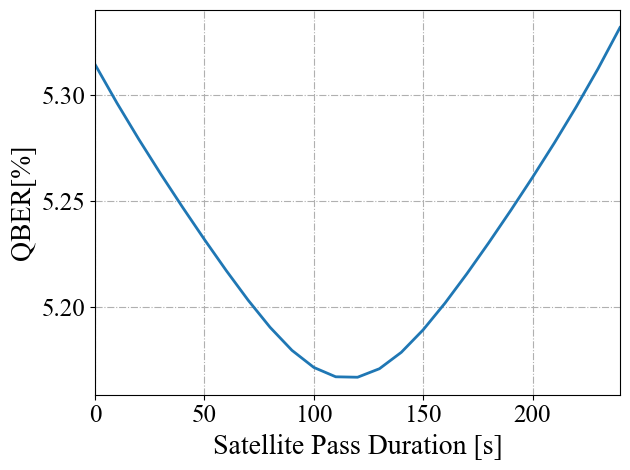

In [7]:
plt.plot(t, qber_values[0][:]*100)
# plt.plot(t, qber_values[1][:]*100, ls='--')
# plt.plot(t, qber_values[2][:]*100, ls=':')

plt.xlabel(r"Satellite Pass Duration [s]")
plt.ylabel(r"QBER[%]")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()
plt.savefig('figure_results/qber_plot.pdf')
# plt.savefig(f'results/qber_{n_s}.png')
# print(f"✅ Saved as: qber_{n_s}.png")

In [ ]:
np.save('results/qber_analysis_bbm92_test1_n_s1_new', qber_values)
np.save('results/yield_analysis_bbm92_test1_n_s1_new', yield_values)

tau_zen = 0.81
tau_zen = 0.75
tau_zen = 0.55


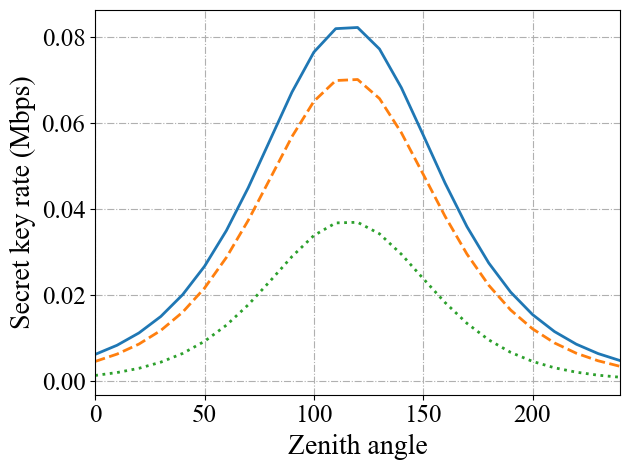

In [10]:
# Q_1, e_1 = compute_Q_1_e_1_ex(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )
# skr_values[idx][jdx] = compute_SKR(
#             qber_values[idx][jdx], yield_values[idx][jdx], Q_1, e_1
#         )
# Save QBER and yield arrays for further analysis
for idx in range(len(tau_zen_lst)):
    print(f"tau_zen = {tau_zen_lst[idx]}")
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        skr_values[idx][jdx] = compute_SKR_BBM92(
            qber_values[idx][jdx],
            yield_values[idx][jdx],
            rep_rate=1e9,
            sifting_coefficient=0.5,
            kr_efficiency=1.22
        )

plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')
plt.plot(t, skr_values[2][:]/10**6, ls=':')


# plt.plot(zenith_angle_deg_list, yield_values[0][:])
# plt.plot(zenith_angle_deg_list, yield_values[1][:], ls='--')

plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()
plt.savefig('figure_results/skr_plot.pdf')

# plt.savefig(f'results/skr_{n_s}.png')
# print(f"✅ Saved as: skr_{n_s}.png")

In [8]:
np.save('results/skr_analysis_bbm92_test1_n_s1_new', skr_values)